In [1]:
import requests
import re
import json
from collections import Counter

import get_tag_data as gd
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
pd.set_option("display.max_rows", 10)

In [4]:
data = pd.read_csv("./data/tags/300pages_main.csv", sep=";", index_col=0)

In [ ]:
data.head()

Собираем тэги из текстовых данных

In [9]:
tag_pat = re.compile(r"#([\w]+)")

data["tags"] = data["text"].str.findall(tag_pat)

Считаем частоты тэгов

In [13]:
class FreqCounter:
    def __init__(self):
        self._freqs = Counter()
        
    def fit(self, series):
        assert isinstance(series, pd.Series)
        for row in series:
            self._freqs.update(row)
        return self
    
    def fit_transform(self, series, quant=None):
        self.fit(series)
        self.quant = quant
        return self.freqs
    
    @property
    def freqs(self):
        data = (pd.Series(self._freqs)
                .sort_values(ascending=False)
                .reset_index()
                .rename({"index": "tag", 0: "freq"}, axis=1))
        if self.quant:
            data = data[data["freq"] >= data["freq"].quantile(self.quant)]
            
        return data

In [14]:
tags_freqs = FreqCounter().fit_transform(data["tags"].dropna())

Оставляем наиболее частые

In [15]:
most_common_tags = tags_freqs[tags_freqs["freq"] > tags_freqs["freq"].quantile(0.9)]

In [16]:
most_common_tags.shape

(2287, 2)

In [19]:
most_common_tags.head()

,tag,freq
0,мастерклассспб,15832
1,мастеркласс,5669
2,спб,3557
3,творчество,3448
4,артмир,2166


Высокочастотные тэги нерелевантны!

In [27]:
mk_pat = re.compile("(мастеркласс)|(мк)")
mk_tags = most_common_tags[most_common_tags["tag"].str.contains(mk_pat)]

d:\coding\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


In [30]:
mk_tags.reset_index(drop=True).to_csv("./data/tags/mk_tags_freq.csv")

Используем тэги, указывающие на проведение мастер-классов в СПб

In [165]:
piter_pat = re.compile(r"#\w*spb|#\w*piter|#\w*спб|#\w*питер+")
piter_tags = data["text"].str.findall(piter_pat)

In [197]:
piter_tag_freqs = FreqCounter().fit_transform(piter_tags.dropna(), quant=0.99)

In [ ]:
piter_tag_freq.head()

In [199]:
piter_tag_freqs.drop(piter_tag_freqs.iloc[:4, :].index, axis=0, inplace=True)

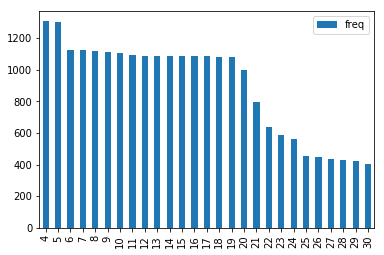

In [216]:
piter_tag_freqs.plot(kind="bar")

In [217]:
piter_tag_freqs.to_csv("./data/piter_tag_freqs.csv", sep=";")

In [220]:
with open("./data/300pages_main.json") as f:
    json_data = json.load(f)

In [228]:
columns = {
    "index": "post_id",
    "taken_at_timestamp": "date",
    "edge_liked_by": "likes",
    "owner": "owner_id"
}

In [229]:
test = pd.DataFrame.from_dict(json_data, orient="index").reset_index().rename(columns=columns)
test.likes = test.likes.map(lambda x: x['count'])
test.owner_id = test.owner_id.map(lambda x: x['id'])

,post_id,text,date,likes,owner_id,is_video
0,BBw6DuMlwRa,Скрапбукинг и Сёрфинг созданы друг для друга😂🏄...,1455447510,32,679346472,False
1,BGRBVuxCYp-,"""Яблоки."" Бумага, пастель. Друзья, такой урове...",1465115004,55,1752570609,False
2,BJwYuf8DnLV,Делали на МК с детишками картины из ниток)\n....,1472609904,7,2207881091,False
3,BKa1dvchMCW,Море вдохновляет творить🐚🌊\n.\n\nСовсем скоро ...,1474034257,25,2306257848,False
4,BLbwuJuF9sD,"Друзья, а у на отличная новость💥 Шьём на заказ...",1476212808,21,2306257848,False


In [3]:
pd.read_csv("./data/piter_tag_freqs.csv", sep=";", index_col=0)

,tag,freq
4,#татуажспб,1309
5,#мкспб,1305
6,#ресницыспб,1128
7,#наращиваниересницспб,1125
8,#микроблейдингспб,1119
9,#косметологспб,1111
10,#ламинированиересницспб,1109
11,#ресницыпитер,1094
12,#косметологпитер,1089
13,#татуажпитер,1088


Будем использовать эти тэги